# Break Out Strategy

### Load the data

In [1]:
import pandas as pd
import pandas_ta as ta
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats

df = pd.read_csv("EURUSD_Candlestick_1_Hour_BID_04.05.2003-15.04.2023.csv")
df=df[df['Volume']!=0]
df.reset_index(drop=True, inplace=True)

df['RSI'] = ta.rsi(df.Close, length=12)
df['EMA'] = ta.ema(df.Close, length=150)
df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=14)

df.tail()

,Gmt time,Open,High,Low,Close,Volume,RSI,EMA,ATR
123836,14.04.2023 16:00:00.000,1.09789,1.09851,1.09722,1.09775,1.429995e+07,20.092619,1.096424,0.001677
123837,14.04.2023 17:00:00.000,1.09775,1.09901,1.09752,1.09871,9.740260e+06,27.485921,1.096455,0.001664
123838,14.04.2023 18:00:00.000,1.09871,1.09989,1.09871,1.09988,9.199190e+06,35.429055,1.096500,0.001629
123839,14.04.2023 19:00:00.000,1.09987,1.09992,1.09921,1.09964,4.669030e+06,34.581386,1.096542,0.001563
123840,14.04.2023 20:00:00.000,1.09964,1.09977,1.09920,1.09922,3.125180e+06,33.070826,1.096577,0.001492


In [2]:
import numpy as np
import pandas as pd

backcandles = 15                
win = backcandles + 1               

above = (np.minimum(df['Open'],  df['Close']) > df['EMA']).astype(int)
below = (np.maximum(df['Open'],  df['Close']) < df['EMA']).astype(int)

# ------------------------------------------------------------------ #
# Rolling “all‑true” test with a fast sum
# ------------------------------------------------------------------ #
#    upt  == 1  ⇔ every candle in the window is above the EMA
#    dnt  == 1  ⇔ every candle in the window is below the EMA
upt = (above.rolling(win, min_periods=win).sum() == win)
dnt = (below.rolling(win, min_periods=win).sum() == win)

signal = np.zeros(len(df), dtype=int)
signal[ upt  &  dnt] = 3          # (theoretically rare / flat on EMA)
signal[ upt  & ~dnt] = 2          # all‑above window
signal[ dnt  & ~upt] = 1          # all‑below window

df['EMASignal'] = signal


In [3]:
import numpy as np
import pandas as pd

def mark_pivots(df: pd.DataFrame, window: int, high_col='High', low_col='Low') -> pd.Series:
    """
    Vectorized replacement for `isPivot()`.

    Parameters
    ----------
    df        : DataFrame that contains OHLC columns.
    window    : int
        Number of bars to look *before* and *after* a candle.
        (Total span = 2*window + 1)
    high_col  : str, default 'High'
    low_col   : str,  default 'Low'

    Returns
    -------
    pd.Series (dtype=int)
        0 = not a pivot  
        1 = pivot high  
        2 = pivot low  
        3 = both high & low  (flat bar inside a very tight range)
    """
    span = 2 * window + 1                       # total length of the centred window

    # Rolling extrema, centred on each bar
    roll_max = df[high_col].rolling(span, center=True).max()
    roll_min = df[low_col].rolling(span,  center=True).min()

    # Boolean masks (NaNs on the edges stay False)
    pivot_high = (df[high_col] >= roll_max) & roll_max.notna()
    pivot_low  = (df[low_col]  <= roll_min) & roll_min.notna()

    # Encode: 1 = high, 2 = low, 3 = both
    pivots = np.zeros(len(df), dtype=int)
    pivots[pivot_high] += 1
    pivots[pivot_low]  += 2

    return pd.Series(pivots, index=df.index, name='isPivot')


window = 7
df['isPivot'] = mark_pivots(df, window)


In [4]:
def pointpos(x):
    if x['isPivot']==2:
        return x['Low']-1e-3
    elif x['isPivot']==1:
        return x['High']+1e-3
    else:
        return np.nan
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [5]:
dfpl = df[300:450]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [6]:
def detect_structure(candle: int,
                     backcandles: int,
                     window: int
                     ) -> tuple[int, int | None]:
    """
    Return a signal only on the *first* candle that breaks the key level.

    2  -> bullish breakout (PH → PL₂ < PL₁ → first close > PH.High)
    1  -> bearish breakout (PL → PH₂ > PH₁ → first close < PL.Low)
    0  -> no pattern
    """
    # ----------------------------------------------------------- #
    # 0) History guard
    # ----------------------------------------------------------- #
    if candle - backcandles < 0:
        return 0, None

    prev_bar = candle - 1
    if prev_bar < 0:                       # no previous bar to compare
        return 0, None

    # ----------------------------------------------------------- #
    # 1) Data slices
    # ----------------------------------------------------------- #
    price_df = df.iloc[candle - backcandles : candle]        # exclude current
    close_now     = df.loc[candle, 'Close']
    close_prev    = df.loc[prev_bar, 'Close']

    # confirmed pivots: idx ≤ candle - window
    piv_df = df.iloc[candle - backcandles : candle - window + 1]

    # ----------------------------------------------------------- #
    # 2) Bullish side (PH → PL₂ → first break up)
    # ----------------------------------------------------------- #
    ph_df = piv_df[piv_df['isPivot'] == 1]
    if not ph_df.empty:
        ph_idx = ph_df.index[-1]
        ph_val = ph_df.loc[ph_idx, 'High']

        # ensure previous candle did NOT already break the level
        if close_now > ph_val and close_prev <= ph_val:

            pl_before = piv_df.loc[:ph_idx - 1]
            pl_before = pl_before[pl_before['isPivot'] == 2]

            pl_after  = piv_df.loc[ph_idx + 1:]
            pl_after  = pl_after[pl_after['isPivot'] == 2]

            if not pl_before.empty and not pl_after.empty:
                pl1_val = pl_before.iloc[-1]['Low']     # last PL before PH
                pl2_val = pl_after['Low'].min()         # any PL after PH

                if pl2_val < pl1_val:                   # sweep condition
                    return 2, ph_idx

    # ----------------------------------------------------------- #
    # 3) Bearish side (PL → PH₂ → first break down)
    # ----------------------------------------------------------- #
    pl_df = piv_df[piv_df['isPivot'] == 2]
    if not pl_df.empty:
        pl_idx = pl_df.index[-1]
        pl_val = pl_df.loc[pl_idx, 'Low']

        if close_now < pl_val and close_prev >= pl_val:

            ph_before = piv_df.loc[:pl_idx - 1]
            ph_before = ph_before[ph_before['isPivot'] == 1]

            ph_after  = piv_df.loc[pl_idx + 1:]
            ph_after  = ph_after[ph_after['isPivot'] == 1]

            if not ph_before.empty and not ph_after.empty:
                ph1_val = ph_before.iloc[-1]['High']    # last PH before PL
                ph2_val = ph_after['High'].max()        # any PH after PL

                if ph2_val > ph1_val:
                    return 1, pl_idx

    # ----------------------------------------------------------- #
    return 0, None


In [7]:
from tqdm import tqdm

df['breakout_signal'] = 0
df['pivot_ref_idx'] = None

start_index = 0
end_index = len(df)

for candle in tqdm(range(start_index, end_index)):
    signal, ref_idx = detect_structure(candle, backcandles=40, window=5)
    df.at[candle, 'breakout_signal'] = signal
    df.at[candle, 'pivot_ref_idx'] = ref_idx

100%|██████████| 123841/123841 [01:23<00:00, 1491.31it/s]


In [8]:
df['breakout_signal'] = df.apply(lambda row: row['breakout_signal'] if row['EMASignal'] == row['breakout_signal'] else 0, axis=1)
df[df['breakout_signal']!=0].head(50)

,Gmt time,Open,High,Low,Close,Volume,RSI,EMA,ATR,EMASignal,isPivot,pointpos,breakout_signal,pivot_ref_idx
283,20.05.2003 16:00:00.000,1.16516,1.16970,1.16457,1.16845,2.936313e+08,60.633173,1.154431,0.002944,2,0,NaN,2,273
881,24.06.2003 15:00:00.000,1.15416,1.15502,1.15111,1.15174,2.568460e+07,34.663327,1.164931,0.002241,1,0,NaN,1,873
2865,17.10.2003 12:00:00.000,1.15878,1.15889,1.15529,1.15627,3.225250e+07,37.480996,1.166454,0.002599,1,0,NaN,1,2836
3395,18.11.2003 15:00:00.000,1.18135,1.19099,1.18128,1.18928,3.176930e+07,75.707035,1.169023,0.003028,2,0,NaN,2,3366
3708,05.12.2003 16:00:00.000,1.21387,1.21673,1.21352,1.21540,2.929037e+08,69.795227,1.202619,0.002620,2,0,NaN,2,3682
3710,05.12.2003 18:00:00.000,1.21501,1.21673,1.21453,1.21582,1.458684e+08,69.649423,1.202955,0.002583,2,0,NaN,2,3682
4017,24.12.2003 13:00:00.000,1.24029,1.24265,1.24000,1.24258,2.921810e+07,63.542086,1.237101,0.001506,2,0,NaN,2,3989
4084,29.12.2003 08:00:00.000,1.24423,1.24738,1.24420,1.24695,3.142290e+07,67.301716,1.241539,0.001531,2,0,NaN,2,4056
4757,05.02.2004 09:00:00.000,1.25480,1.25919,1.25429,1.25810,3.322390e+07,72.631950,1.251257,0.002014,2,0,NaN,2,4734
4860,11.02.2004 16:00:00.000,1.27007,1.28364,1.27007,1.28162,2.960741e+08,74.491980,1.263976,0.003497,2,0,NaN,2,4849


In [16]:
import plotly.graph_objects as go

def plot_breakouts_with_candles(df, start_idx=None, end_idx=None):
    """
    Plots candlestick chart with breakout markers and pivot reference lines.

    Requirements in df:
    - 'Open', 'High', 'Low', 'Close'
    - 'breakout_signal' column (2 = bullish, 1 = bearish, 0 = no signal)
    - 'pivot_ref_idx' column (index of the pivot candle used for the breakout)
    """

    # Slice the DataFrame
    if start_idx is None:
        start_idx = df.index[0]
    if end_idx is None:
        end_idx = df.index[-1]
    dfpl = df.loc[start_idx:end_idx].copy()

    # Create figure
    fig = go.Figure()

    # Candlestick chart
    fig.add_trace(go.Candlestick(
        x=dfpl.index,
        open=dfpl["Open"],
        high=dfpl["High"],
        low=dfpl["Low"],
        close=dfpl["Close"],
        name="Candles"
    ))

    # Loop through breakout signals
    for idx, row in dfpl.iterrows():
        signal = row.get("breakout_signal", 0)
        pivot_idx = row.get("pivot_ref_idx", None)

        if signal == 2 and pivot_idx in df.index:
            # Bullish breakout
            y_marker = row["Low"] - (row["High"] - row["Low"]) * 0.02
            fig.add_trace(go.Scatter(
                x=[idx],
                y=[y_marker],
                mode="markers",
                marker=dict(symbol="triangle-up", color="white", size=20),
                name="Bullish Breakout"
            ))
            # Reference line from pivot high to current candle
            pivot_high = df.loc[pivot_idx, "High"]
            fig.add_shape(
                type="line",
                x0=pivot_idx,
                x1=idx,
                y0=pivot_high,
                y1=pivot_high,
                line=dict(color="purple", dash="dash")
            )

        elif signal == 1 and pivot_idx in df.index:
            # Bearish breakout
            y_marker = row["High"] + (row["High"] - row["Low"]) * 0.02
            fig.add_trace(go.Scatter(
                x=[idx],
                y=[y_marker],
                mode="markers",
                marker=dict(symbol="triangle-down", color="white", size=20),
                name="Bearish Breakout"
            ))
            # Reference line from pivot low to current candle
            pivot_low = df.loc[pivot_idx, "Low"]
            fig.add_shape(
                type="line",
                x0=pivot_idx,
                x1=idx,
                y0=pivot_low,
                y1=pivot_low,
                line=dict(color="purple", dash="dash")
            )

    # Layout styling
    fig.update_layout(
        title="Candlestick Chart with Breakout Signals",
        width=1200,
        height=800,
        plot_bgcolor='black',
        paper_bgcolor='black',
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False)
    )

    fig.show()


In [21]:
plot_breakouts_with_candles(df, start_idx=3650, end_idx=3780)

In [23]:
from backtesting import Backtest, Strategy
import numpy as np
def SIGNAL():
    return df.breakout_signal

class MyStrat(Strategy):
    mysize = 0.99
    
    atr_multiplier = 1.5  # Stop-loss distance = ATR * atr_multiplier.
    tp_sl_ratio    = 1  # Take profit = (ATR * atr_multiplier) * tp_sl_ratio.

    def init(self):
        self.signal1 = self.I(SIGNAL)
        self.atr = self.I(lambda: df["ATR"].values)
    
    def next(self):
        if self.position:
            return

        close_now = self.data.Close[-1]
        current_atr = self.atr[-1]

        if current_atr is None or np.isnan(current_atr):
            return

        sl_distance = current_atr * self.atr_multiplier
        tp_distance = sl_distance * self.tp_sl_ratio

        sig = self.signal1[-1]
        
        # Bullish breakout signal: enter a long trade.
        if sig == 2:
            entry_price = close_now
            sl_price = entry_price - sl_distance
            tp_price = entry_price + tp_distance
            self.buy(size=self.mysize, sl=sl_price, tp=tp_price)
        
        # Bearish breakout signal: enter a short trade.
        elif sig == 1:
            entry_price = close_now
            sl_price = entry_price + sl_distance
            tp_price = entry_price - tp_distance
            self.sell(size=self.mysize, sl=sl_price, tp=tp_price)

# Create the backtest instance.
bt = Backtest(
    df,
    MyStrat,
    cash=10000,
    margin=1/1,
    commission=0.000,
)

# Optimize the ATR multiplier and TP/SL ratio parameters to maximize returns.
stats, heatmap = bt.optimize(
    atr_multiplier=np.arange(0.5, 5.1, 0.5).tolist(),
    tp_sl_ratio=np.arange(0.5, 5.1, 0.5).tolist(),
    maximize='Return [%]',
    return_heatmap=True,
)

stats = bt.run()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_153280\4069936825.py:46: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



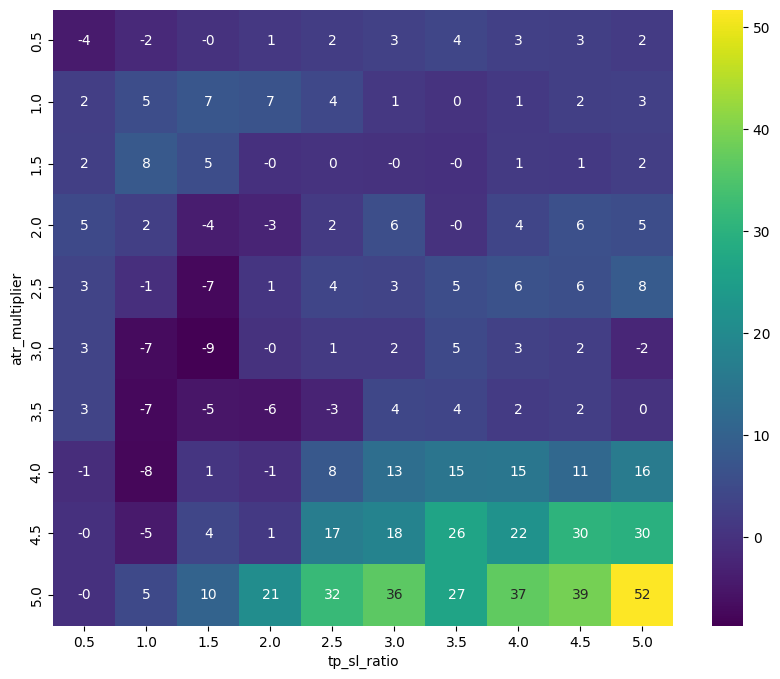

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [71]:
bt.run(atr_multiplier=1, tp_sl_ratio=1)

Start                                     0.0
End                                  123840.0
Duration                             123840.0
Exposure Time [%]                     0.71705
Equity Final [$]                  10528.14756
Equity Peak [$]                   10667.98016
Return [%]                            5.28148
Buy & Hold Return [%]                 -2.1219
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -1.31077
Avg. Drawdown [%]                    -0.32209
Max. Drawdown Duration                22366.0
Avg. Drawdown Duration             2994.17647
# Trades                                208.0
Win Rate [%]                         53.84615
Best Trade [%]                         2.2433
Worst Trade [%]                      -0.34197
Avg. Trade [%]                    

In [72]:
bt.plot()

c:\CodeLab\Python\Lib\site-packages\backtesting\_plotting.py:660: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

c:\CodeLab\Python\Lib\site-packages\backtesting\_plotting.py:660: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p5488', ...)